In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import BallTree

import shapely
from shapely.errors import WKTReadingError
from shapely import Point

from scipy import stats
import spreg

from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy

In [13]:
bikes = pd.read_csv("JC-202303-citibike-tripdata.csv")

start_stations = bikes[['start_station_id', 'start_lat', 'start_lng']]
end_stations = bikes[['end_station_id', 'end_lat', 'end_lng']]

start_stations.rename(columns={"start_station_id": "station_id", "start_lat": "Latitude", "start_lng": "Longitude"}, 
                      inplace=True)
end_stations.rename(columns={"end_station_id": "station_id", "end_lat": "Latitude", "end_lng": "Longitude"},
                   inplace=True)

start_stations = start_stations.groupby(['station_id'])['Latitude', 'Longitude'].agg(pd.Series.mode).reset_index(0)
end_stations = end_stations.groupby(['station_id'])['Latitude', 'Longitude'].agg(pd.Series.mode).reset_index(0)

bikes = start_stations.append(end_stations, ignore_index=True)
bikes = bikes[bikes['Latitude'].notna() & bikes['Longitude'].notna()]
bikes = bikes.groupby(['station_id'])['Latitude', 'Longitude'].mean().reset_index(0)

ply_coord = [Point(x, y) for x, y in zip(bikes.Latitude, bikes.Longitude)]
bikes = gpd.GeoDataFrame(bikes, geometry=ply_coord, crs ="EPSG:4326")
bikes.drop(bikes.iloc[:, 0:-1], axis = 1, inplace = True)
bikes.head()

,geometry
0,POINT (40.70355 -74.00670)
1,POINT (40.70472 -74.00926)
2,POINT (40.70470 -74.00803)
3,POINT (40.70706 -74.00732)
4,POINT (40.70906 -74.01043)


In [14]:
noises = pd.read_csv("Noise_Complaints__in_2017_.csv")
noises = noises[noises['Latitude'].notna() & noises['Longitude'].notna()]
ply_coord = [Point(x, y) for x, y in zip(pd.to_numeric(noises.Latitude), pd.to_numeric(noises.Longitude))]
noises = gpd.GeoDataFrame(noises, geometry=ply_coord, crs ="EPSG:4326")
noises.drop(noises.iloc[:, 0:-1], axis = 1, inplace = True)
noises.head()

,geometry
0,POINT (40.62887 -74.03022)
1,POINT (40.86361 -73.92718)
2,POINT (40.60549 -74.00689)
3,POINT (40.60000 -73.74764)
4,POINT (40.87278 -73.88541)


In [15]:
poles = pd.read_csv("Mobile_Telecommunications_Franchise_Pole_Reservation_Locations.csv")
poles = poles[poles['Latitude'].notna() & poles['Longitude'].notna()]
ply_coord = [Point(x, y) for x, y in zip(poles.Latitude, poles.Longitude)]
poles = gpd.GeoDataFrame(poles, geometry=ply_coord, crs ="EPSG:4326")
poles.drop(poles.iloc[:, 0:-1], axis = 1, inplace = True)
poles.head()

,geometry
0,POINT (40.67182 -73.73891)
1,POINT (40.66783 -73.74032)
2,POINT (40.66945 -73.73022)
3,POINT (40.66855 -73.73365)
4,POINT (40.65440 -73.73164)


In [16]:
signs = pd.read_csv("Real_Time_Passenger_Information_Sign_Locations.csv")
signs = signs[signs['Latitude'].notna() & signs['Longitude'].notna()]
ply_coord = [Point(x, y) for x, y in zip(signs.Latitude, signs.Longitude)]
signs = gpd.GeoDataFrame(signs, geometry=ply_coord, crs ="EPSG:4326")
signs.drop(signs.iloc[:, 0:-1], axis = 1, inplace = True)
signs.head()

,geometry
0,POINT (40.74922 -74.00290)
1,POINT (40.76771 -73.96425)
2,POINT (40.63926 -74.01595)
3,POINT (40.64729 -74.08112)
4,POINT (40.70310 -73.79611)


In [17]:
subway = pd.read_csv("DOITT_SUBWAY_ENTRANCE_01_13SEPT2010.csv")
subway = subway[subway['the_geom'].notna()]
subway['geometry'] = subway['the_geom'].apply(lambda x: shapely.wkt.loads(x))
subway['geometry'] = gpd.GeoSeries(subway['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
subway.drop(subway.iloc[:, 0:-1], axis = 1, inplace = True)
subway.head()

,geometry
0,POINT (40.84917 -73.86836)
1,POINT (40.84913 -73.86821)
2,POINT (40.84122 -73.87350)
3,POINT (40.84145 -73.87289)
4,POINT (40.84082 -73.87962)


In [18]:
crashes = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes.csv")
crashes = crashes[crashes['LATITUDE'].notna() & crashes['LONGITUDE'].notna()]
crashes = crashes[(crashes['LATITUDE'] != 0)  & (crashes['LONGITUDE'] != 0)]
crashes['LATITUDE'] = round(crashes["LATITUDE"], 5)
crashes['LONGITUDE'] = round(crashes["LONGITUDE"], 5)
crashes['LOCATION'] = list(zip(crashes['LATITUDE'], crashes['LONGITUDE']))
crashes['crashCount'] = crashes.groupby('LOCATION')['LOCATION'].transform('count')
crashes.drop(crashes.iloc[:, 0:4], axis = 1, inplace=True)
crashes.drop(crashes.iloc[:, 3:-1], axis = 1, inplace=True)
crashes.drop_duplicates(inplace=True)
ply_coord = [Point(x, y) for x, y in zip(crashes.LATITUDE, crashes.LONGITUDE)]
crashes = gpd.GeoDataFrame(crashes, geometry=ply_coord, crs ="EPSG:4326")
crashes.drop(crashes.iloc[:, 0:3], axis = 1, inplace = True)
crashes.reset_index(drop=True, inplace=True)
crashes.head()

,crashCount,geometry
0,3,POINT (40.66720 -73.86650)
1,45,POINT (40.68330 -73.91727)
2,108,POINT (40.70918 -73.95682)
3,4,POINT (40.86816 -73.83148)
4,1,POINT (40.67172 -73.89710)


In [19]:
def get_nearest(src_points, candidates, k_neighbors=10):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

In [20]:
data = nearest_neighbor(crashes, signs, return_dist=True)
data.rename(columns={"distance": "signDist"}, inplace=True)
data = data[['signDist']]
data = data.join(crashes)

In [21]:
data['bikeDist'] = nearest_neighbor(crashes, bikes, return_dist=True)['distance']
data['noiseDist'] =  nearest_neighbor(crashes, noises, return_dist=True)['distance']
data['poleDist'] = nearest_neighbor(crashes, poles, return_dist=True)['distance']
data['subwayDist'] = nearest_neighbor(crashes, subway, return_dist=True)['distance']

In [22]:
data[['latitude', 'longitude']] = data.apply(lambda p: (p.geometry.x, p.geometry.y), axis=1, result_type='expand')
data = data[['geometry', 'latitude', 'longitude', 'bikeDist', 'noiseDist', 'poleDist', 'signDist', 'subwayDist', 'crashCount']]
data

,geometry,latitude,longitude,bikeDist,noiseDist,poleDist,signDist,subwayDist,crashCount
0,POINT (40.66720 -73.86650),40.66720,-73.86650,11130.595708,16.730731,58.011889,1372.316387,1005.631798,3
1,POINT (40.68330 -73.91727),40.68330,-73.91727,7758.900813,41.397784,12.807623,514.456526,308.913773,45
2,POINT (40.70918 -73.95682),40.70918,-73.95682,3366.328950,43.435910,38.706460,1452.082034,112.761048,108
3,POINT (40.86816 -73.83148),40.86816,-73.83148,9218.388777,71.178313,56.457316,3502.513281,1215.812722,4
4,POINT (40.67172 -73.89710),40.67172,-73.89710,9884.995968,44.088912,49.423976,724.798074,283.046837,1
...,...,...,...,...,...,...,...,...,...
258286,POINT (40.68198 -73.79459),40.68198,-73.79459,13540.319698,14.874459,95.434948,1979.525471,2285.013183,1
258287,POINT (40.75197 -73.93181),40.75197,-73.93181,1337.857335,26.884545,66.591161,1029.104754,103.809280,1
258288,POINT (40.81455 -73.86500),40.81455,-73.86500,7326.172178,6.603426,16.796905,3146.846704,1840.230070,1
258289,POINT (40.59563 -73.94366),40.59563,-73.94366,13126.329039,107.869747,191.125427,1234.682967,969.976927,1


In [24]:
from sklearn.ensemble import HistGradientBoostingRegressor
regr = HistGradientBoostingRegressor()

X = data[['latitude', 'longitude', 'bikeDist', 'noiseDist', 'poleDist', 'signDist', 'subwayDist']]
y = data['crashCount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

regr_model = regr.fit(X_train, y_train)
y_preds = regr_model.predict(X_test)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_preds, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [ ]:
regrs = [KNeighborsRegressor(),
        GradientBoostingRegressor(),
        ExtraTreesRegressor(),
        RandomForestRegressor()
       ]

HistGradientBoostingRegressor

In [25]:
mae = metrics.mean_absolute_error(y_test, y_preds)
mse = metrics.mean_squared_error(y_test, y_preds)
r2 = metrics.r2_score(y_test, y_preds)

print("The model performance for testing set")
print("--------------------------------------")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for testing set
--------------------------------------
MAE is 7.15589533435819
MSE is 320.22201473274936
R2 score is 0.13684772923045008


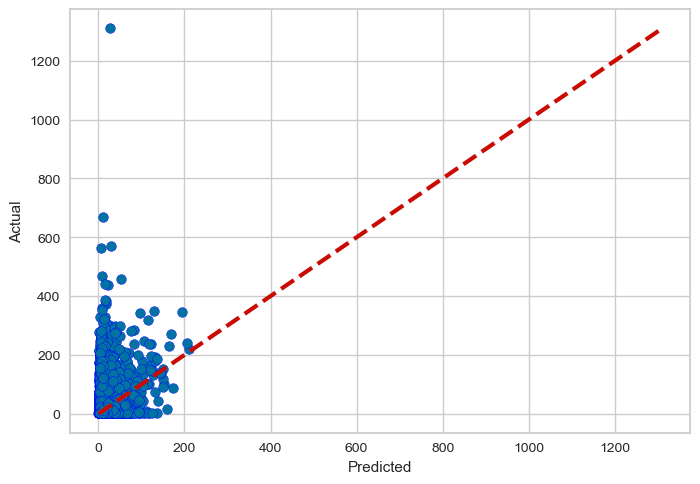

In [26]:
fig, ax = plt.subplots()
ax.scatter(y_preds, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()